Importy:

In [1]:
from scipy import sparse
import numpy as np
import pandas as pd
from enum import Enum
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import graphviz
import time
from IPython.display import display

E:\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Poniżej funkcje do służace do obliczania metryk z poprzedniego zadania. W przypadku eksperymentów została wykorzystana jedynie metryka przyrostu informacji (`infogain`), więc tylko one zostały poniżej zamieszczone.

In [2]:
def freq(x, prob: bool = True) -> list:
    if type(x) == sparse.csr_matrix or type(x) == sparse.csc_matrix:
        nonzero = x.nonzero()[0]
        uniques = set(nonzero)

        count_nonzero = len(nonzero)
        counts = {
            0: x.shape[0] - count_nonzero,
            1: count_nonzero
        }
        total = sum(counts.values())

        return [uniques, counts if prob is False else {key: val / total for key, val in counts.items()}]

    counts = {}

    for val in x:
        if val in counts.keys():
            counts[val] += 1
            continue

        counts[val] = 1

    xi = np.array(list(counts.keys()))
    ni = np.array(list(counts.values()))

    return [xi, ni if prob is False else ni / np.sum(ni)]


def freq2(x, y, prob: bool = True) -> list:
    if (type(x) == sparse.csr_matrix or type(x) == sparse.csc_matrix) and (type(y) == sparse.csr_matrix or type(y) == sparse.csc_matrix):
        x_nonzero = x.nonzero()[0]
        y_nonzero = y.nonzero()[0]

        uniques_x = set(x_nonzero)
        uniques_y = set(y_nonzero)
        intersection_x_y = uniques_x.intersection(uniques_y)

        count_intersection = len(intersection_x_y)
        count_x_nonzero = len(x_nonzero)
        count_y_nonzero = len(y_nonzero)
        count_shared_zeros = x.shape[0] - count_x_nonzero + y.shape[0] - count_y_nonzero

        counts = {
            (0, 0): count_shared_zeros,
            (0, 1): count_y_nonzero - count_intersection,
            (1, 0): count_x_nonzero - count_intersection,
            (1, 1): count_intersection
        }
        # print(counts)
        total = sum(counts.values())

        return [uniques_x, uniques_y, counts if prob is False else {key: val / total for key, val in counts.items()}]

    counts = {}

    for x_val, y_val in zip(x, y):
        key = (x_val, y_val)

        if key in counts.keys():
            counts[key] += 1
        else:
            counts[key] = 1

    counts = np.array(list(counts.values()))
    return [freq(x)[0], freq(y)[0], counts / np.sum(counts) if prob is True else counts]


def entropy(x, y=None, conditional_reverse: bool = False):
    if y is None:
        uniques, probs = freq(x)
    else:
        uniques_x, uniques_y, probs = freq2(x, y)

        if conditional_reverse is True and y is not None:
            uniques_x, probs_x = freq(x)
            entropy_y = entropy(y)

            return sum(prob * entropy_y for prob in probs_x)

    return -np.sum(probs * np.log2(probs))


def infogain(x, y, reverse: bool = False):
    uniques_x, uniques_y, probs = freq2(x, y)
    return entropy(x) + entropy(y) - entropy(x, y)


Klasa pomocnicza jako enum definiująca, które funkcje nieczystości wykorzystać:

In [3]:
class DirtMetricEnum(Enum):
    INFO_GAIN = 'info_gain'
    GINI_GAIN = 'gini_gain'

Klasa pomocnicza odpowiadająca za parametry dla drzewa decyzyjnego:

In [4]:
class DecisionTreeParams:
    def __init__(self, depth: int = 10, number_of_nodes: int = None,
                 threshold_value: int = None, dirt_metric: DirtMetricEnum = DirtMetricEnum.INFO_GAIN):
        self.depth = depth
        self.number_of_nodes = number_of_nodes
        self.threshold_value = threshold_value
        self.dirt_metric = dirt_metric

    def set_params(self, depth: int = 10, number_of_nodes: int = None,
                   threshold_value: int = None, dirt_metric: DirtMetricEnum = DirtMetricEnum.INFO_GAIN):
        self.depth = depth
        self.number_of_nodes = number_of_nodes
        self.threshold_value = threshold_value
        self.dirt_metric = dirt_metric

    def get_params_as_dict(self) -> dict:
        return {
            'depth': self.depth,
            'number_of_nodes': self.number_of_nodes,
            'threshold_value': self.threshold_value,
            'dirt_metric': self.dirt_metric,
        }


Poniżej definicja klasy reprezentującej pojedynczy węzeł w drzewie. Zawiera w sobie wskaźniki na dwóch potomków oraz na rodzica. Ponadto przechowuje wszystkie klasy, ich liczności, prawodpodobieństwa oraz wskazanie klasy z najwyższym prawdopodobieństwem.

Opis metod: 
* depth - Metoda rekurencyjna wyliczająca głębokość węzła.
* is_leaf - Metoda sprawdzająca, czy dany węzeł jest liściem. Liściem może być węzeł nie posiadający żadnych potomków.
* get_all_leafs - Metoda rekurencyjna zwracająca wszystkie liście dla węzła.get_
* get_all_leafs_iter - Wersja iteracyjna metody zwracającej wszystkie liście węzła.

In [5]:
class Node:
    def __init__(self):
        self.id = None

        self.left = None
        self.right = None
        self.parent = None

        self.impurity_value = None

        self.best_attribute = None
        self.best_attribute_index = None

        self.classes = None
        self.classes_count = None
        self.classes_probs = None
        self.class_best = None

    def depth(self):
        depth = 1
        if self.parent is not None:
            depth += self.parent.depth()

        return depth

    def is_leaf(self):
        return self.left is None and self.right is None

    def get_all_leafs(self, leafs: list = []):
        if self.is_leaf():
            leafs.append(self)
            return leafs

        if self.left is not None:
            return self.left.get_all_leafs(leafs)

        if self.right is not None:
            return self.right.get_all_leafs(leafs)

    def get_all_leafs_iter(self):
        successors = [self]
        leafs = []

        while len(successors) > 0:
            node = successors.pop(0)
            leafs.append(node)

            if node.left is not None:
                successors.append(node.left)

            if node.right is not None:
                successors.append(node.right)

        return successors


Poniżej obiekt klasy reprezentującej klasyfikator binarnego drzewa decyzyjnego. Jego właściwościami są: wskaźnik na korzeń drzewa, obiekt reprezentujący parametry drzewa oraz licznik do nadawania węzłom unikalnego indektyfikatora.

Opis metod:
* predict - Metoda opowiadająca za predykcję klas na atrybutach testowych. Dla każdego wiersza danych testowych rozpatrywany jest atrybut, który w danym węźle miał największy przyrost informacji. Jeżeli węzeł jest liściem, to wiemy już jaka to jest klasa i możemy ją przypisać jako tą przewidywaną. W przeciwnym wypadku przejście do następnego węzła jest rozpatrywane na podstawie wartości wybranego atrybutu.

* get_params - Metoda pozwalająca na pobranie obiektu reprezentującego atrybuty drzewa decyzyjnego:
* set_params - Metoda pozwalająca na ustawienie obiektu reprezentującego atrybuty drzewa decyzyjnego.

* build_tree - Rekurencyjna metoda odpowiadająca za budowanie drzewa decyzyjnego.
    * Na początku wybierana jest metoda do policzenia miary zanieczyszczenia, a następnie obliczana jest miara zanieczyszczenia dla każdej z kolumn atrybutów.
    * Następnie następuje wyznaczenie indeksu kolumny atrybutów z największą miarą zanieczyszczenia oraz największej miary zanieczyszczenia.
    * Następnie następuje ustawienie właściwości dla danego węzła.
    * Po ustawieniu sprawdzane są warunku zatrzymania się rozrastania drzewa - wtedy dany węzeł będzie liściem.
    * W przypadku dalszego rozwoju drzewa wybierany jest najlepszy atrybut w danym momencie dla danego węzła, a następnie dokonywany jest podział danych na negatywy oraz pozytywy. W przypadku spełniania warunku stopu zawsze będzie wybierany ten sam atrybut jako najlepszy (pierwszy z listy), ponieważ przy jednej klasie decyzyjnej wartość miary zanieczyszczenia będzie dla wszystkich atrybutów taka sama.
    * Na koniec tworzone są potomki dla węzła oraz wywołanie dalszej procedury rozbudowy drzewa jako poddrzewo dla negatywów oraz pozytywów.
    
* pruning_conditions - metoda sprawdzająca, czy zachodzą warunki, aby drzewo mogło zostać przycięte.
* split - Metoda statyczna odpowiadająca za rozdzielanie danych na negatywy oraz pozytywy.
* is_sparse - Metoda statyczna sprawdzająca czy wybrana kolumna danych jest typu macierzy rzadkiej.
* tree_str - Metoda oznaczona jako właściwość zwracająca jako łańcuch znaków reprezentację zbudowanego drzewa decyzyjnego w formacie `dot`. Wykorzystywana do wizualizacji drzewa decyzyjnego. Węzły liści (decyzyjne) zostały oznaczone jako prostokąty i wypisują 'Terminal' zamiast najlepszego atrybutu dla węzła.
* tree_ - Metoda działająca podobnie do `tree_str`, jednak ta metoda zwraca obiekt typu `Digraph`.

In [6]:
class DecisionTree:
    def __init__(self, params: DecisionTreeParams = DecisionTreeParams()):
        self.root = None
        self.params: DecisionTreeParams = params
        self.id_counter: int = 0

    def fit(self, x, y):
        self.root = Node()
        self.build_tree(x, y, self.root)
        
    def predict(self, x):
        y = []

        for i in range(x.shape[0]):
            node = self.root

            while True:
                if node.is_leaf():
                    y.append(node.class_best)
                    break

                attribute_value = bool(x.iloc[i, node.best_attribute_index])

                if attribute_value is False:
                    node = node.left
                    continue

                if attribute_value is True:
                    node = node.right
                    continue

        return y
    
    def set_params(self, params: DecisionTreeParams):
        self.params = params

    def get_params(self):
        return self.params

    def cv_score(self):
        pass
    
    def build_tree(self, x, y, node: Node):
        impurity_method = infogain if self.params.dirt_metric == DirtMetricEnum.INFO_GAIN else ginigain
        is_sparse = self.is_sparse(x) and self.is_sparse(y)

        uniques_y, probs_y = freq(y)
        impurity_values = [impurity_method(x[:, column] if is_sparse else x[column], y)
                           for column in (range(x.shape[1]) if is_sparse else x.columns)]

        max_index = np.argmax(impurity_values)
        max_value = impurity_values[max_index]
        
        node.impurity_value = max_value
        node.id = f'{self.id_counter}'
        node.classes, node.classes_count = freq(y, prob=False)
        node.classes_probs = probs_y
        node.class_best = uniques_y[np.argmax(probs_y)]

        self.id_counter += 1
        
        if max_value == 0 or len(impurity_values) == 1 or len(uniques_y) == 1 or self.pruning_conditions(node):
            return
        
        node.best_attribute = x.columns[max_index]
        node.best_attribute_index = max_index
        x_negatives, x_positives, y_negatives, y_positives = self.split(x, y, max_index)
        
        left = Node()
        left.parent = node
        node.left = left
        self.build_tree(x_negatives, y_negatives, left)

        right = Node()
        right.parent = node
        node.right = right
        self.build_tree(x_positives, y_positives, right)
        
    def pruning_conditions(self, node) -> bool:
        if node.depth() > self.params.depth:
            return True

        return False
    
    @staticmethod
    def split(x, y, index):
        is_sparse = DecisionTree.is_sparse(x) and DecisionTree.is_sparse(y)

        if is_sparse:
            set1 = set(np.arange(x.shape[1]))
            set2 = set(x[:, index])
            intersect = list(set1.intersection(set2))
            print(intersect)

            return intersect

        column = x[x.columns[index]]

        x_negatives = x[column < 1]
        x_positives = x[column > 0]

        y_negatives = y[column < 1]
        y_positives = y[column > 0]

        return x_negatives, x_positives, y_negatives, y_positives
    
    @staticmethod
    def is_sparse(column):
        return type(column) == sparse.csr_matrix or type(column) == sparse.csc_matrix
    
    @property
    def tree_str(self):
        if self.root is None:
            return None

        dot = 'digraph G {'
        successors = [self.root]

        while len(successors) > 0:
            node = successors.pop(0)

            shape = 'box' if node.best_attribute is None else 'ellipse'
            label = f'info gain: {node.impurity_value}\n classes: {node.classes}\n counts: {node.classes_count}\n probs: {node.classes_probs}\n best class: {node.class_best}'
            label = f'{node.best_attribute if node.best_attribute is not None else "Terminal"}\n {label}'
            dot += f'{node.id} [shape="{shape}", label="{label}"]'

            if node.is_leaf():
                continue

            dot += f'{node.id}->{node.left.id} [label="False"]\n'
            successors.append(node.left)

            dot += f'{node.id}->{node.right.id} [label="True"]\n'
            successors.append(node.right)

        return dot + '}'

    @property
    def tree_(self):
        def add_nodes(dot_var):
            dot_var.attr('node')
            successors = [self.root]

            while len(successors) > 0:
                node = successors.pop(0)

                shape = 'box' if node.best_attribute is None else 'ellipse'
                label = f'info gain: {node.impurity_value}\n classes: {node.classes}\n counts: {node.classes_count}\n probs: {node.classes_probs}\n best class: {node.class_best}'
                label = f'{node.best_attribute if node.best_attribute is not None else "Terminal"}\n {label}'

                dot_var.node(node.id, label=label, shape=shape)

                if node.is_leaf() is False:
                    successors.append(node.left)
                    successors.append(node.right)

            return dot_var

        def add_edges(dot_var):
            dot_var.attr('edge')
            successors = [self.root]

            while len(successors) > 0:
                node = successors.pop(0)

                if node.is_leaf() is True:
                    continue

                dot_var.edge(node.id, node.left.id)
                successors.append(node.left)

                dot_var.edge(node.id, node.right.id)
                successors.append(node.right)

            return dot_var

        if self.root is None:
            return None

        dot = graphviz.Digraph()
        add_nodes(dot)
        add_edges(dot)

        return dot

Poniżej funkcja odpowiadająca za wykonanie eksperymentu.
Dzieli ona dostarczone dane na zbiory trenujące oraz testowe. Następnie mierzy ona czas dla uczenia się modelu oraz wyznacza dokładność klasyfikacji.
Dodatkowo wizualizuje ona drzewo decyzyjne.

In [7]:
def experiment(x, y, model, visualize: bool = True):
    X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.5, test_size=0.5, random_state=0)

    t1 = time.time()
    model.fit(X_train, y_train)
    t2 = time.time()
    print(f'Time of fitting for zoo: {t2 - t1}s')

    y_pred = model.predict(X_test)
    print(f'accuracy score: {accuracy_score(y_test, y_pred)}')

    if visualize:
        s = graphviz.Source(model.tree_str, format='png')
        display(s)

Poniżej główne ciało programu, w którym następuje wczytanie danych, przygotowanie ich oraz wykonanie eksperymentów.

zoo experiment my tree
Time of fitting for zoo: 0.06998372077941895s
accuracy score: 0.8823529411764706


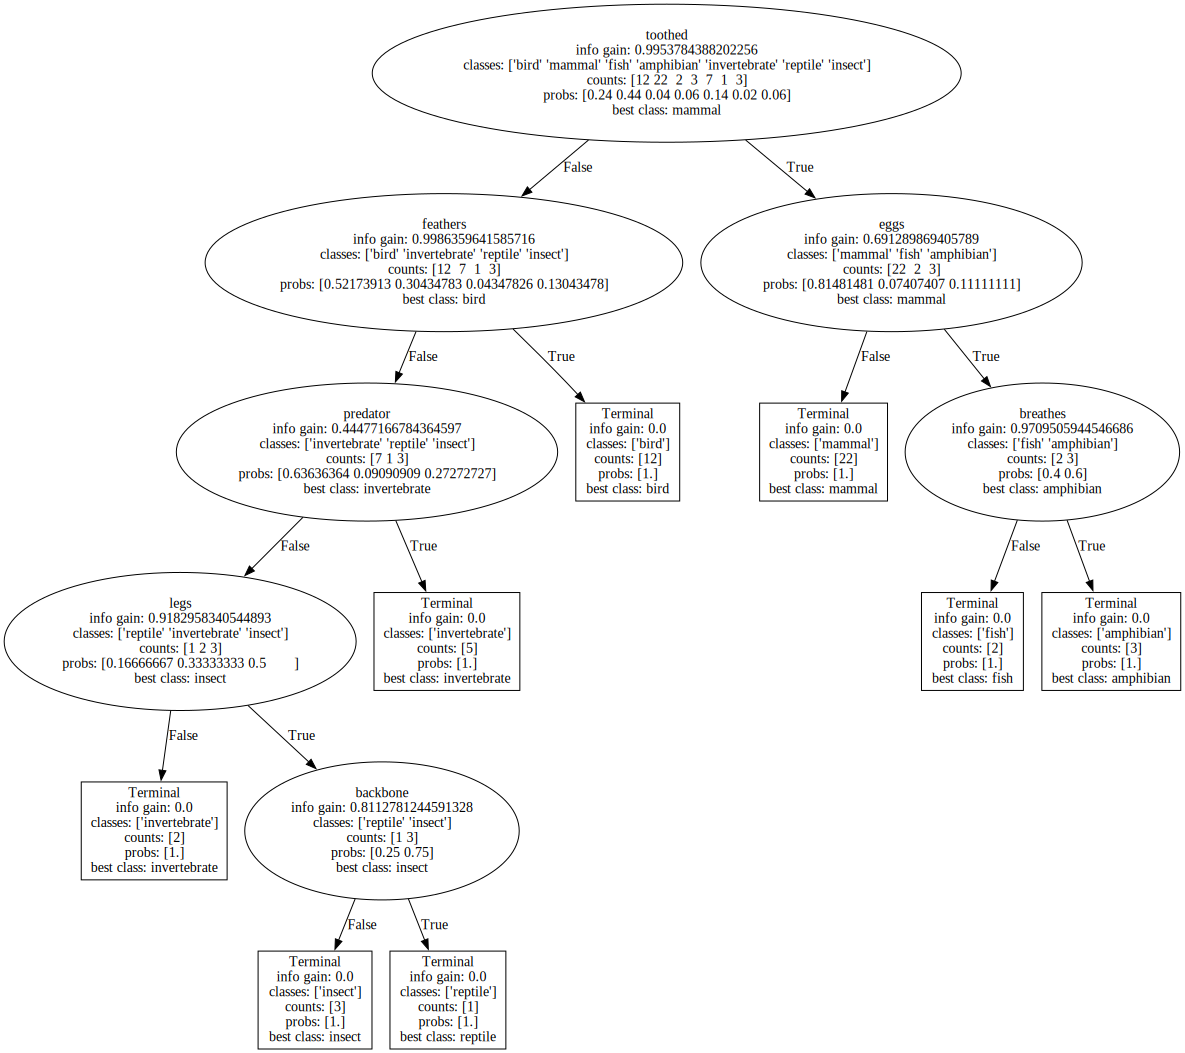

In [8]:
if __name__ == '__main__':
    zoo = pd.read_csv('E:\Programowanie\Python\computational-intelligence\machine-learning-1\zad2\zoo.csv')

    X = zoo.drop(['animal', 'type'], axis=1)
    X['legs'] = X['legs'] > np.mean(X['legs'])
    Y = zoo['type']

    print('zoo experiment my tree')
    experiment(X, Y, DecisionTree())

In [9]:
    print('zoo experiment sklearn tree')
    experiment(X, Y, DecisionTreeClassifier(), False)

zoo experiment sklearn tree
Time of fitting for zoo: 0.0060007572174072266s
accuracy score: 0.9215686274509803
